In [4]:
import multiprocessing
import os.path
from itertools import chain
from typing import Dict

import numpy as np
import pandas as pd
import qnorm
import seaborn
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
from scipy.stats import gmean, spearmanr
from tqdm import tqdm



stats = importr('stats')

N_PROCS = multiprocessing.cpu_count() - 1
P_THRESHOLD = -np.log10(0.05)
GENDER = None  # male / female

In [5]:
filtered_pathways = list()
for database in os.listdir("/home/xvvvx/oncobox/data/pathways"):
    db_pathways = pd.read_csv(os.path.join("/home/xvvvx/oncobox/data/pathways", database, "arr.csv"), index_col=0)
    filtered_pathways_labels = db_pathways.apply(lambda x: x.value_counts(), axis=0).drop([0]).sum() >= 10
    len_b4 = len(db_pathways.index)
    db_pathways = db_pathways.loc[:, filtered_pathways_labels]
    print(database, f"{len(db_pathways.columns)}/{len_b4}")
    filtered_pathways.extend(db_pathways.columns)
print("Total filtered pathways:", len(filtered_pathways))

NCI 1.123 376/2214
Metabolism 1.123 68/1038
Qiagen 1.123 278/2493
KEGG Adjusted 1.123 233/5593
Reactome 1.123 500/6105
Biocarta 1.123 179/1082
Total filtered pathways: 1634


In [6]:
RAW_DATASET = "data/pancan/raw/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv"

normalized_path = "data/pancan/normalized.tsv"
normalized: pd.DataFrame
if not os.path.exists(normalized_path):
    raw_data = pd.read_csv(RAW_DATASET, sep="\t", index_col=0)
    print(f"Raw dataset shape {raw_data.shape}")
    raw_data = raw_data.fillna(0)
    raw_data = raw_data.add(1)
    raw_data.index.name = "SYMBOL"
    raw_data = raw_data.rename(index=lambda gene: gene.split("|")[0]).drop(["?"])
    raw_data = raw_data.groupby(["SYMBOL"]).sum()
    normalized = qnorm.quantile_normalize(raw_data, ncpus=N_PROCS)
    normalized.to_csv(normalized_path, sep="\t")
else:
    print(f"Using cached {normalized_path}")
    normalized = pd.read_csv(normalized_path, sep="\t", index_col=0)
print(f"Normalized dataset shape {normalized.shape}")
print(f"Index duplicates: {len(normalized.index) != len(set(normalized.index))}")

Using cached data/pancan/normalized.tsv
Normalized dataset shape (20501, 11069)
Index duplicates: False


In [7]:

anno_path = "data/pancan/anno.tsv"
anno: pd.DataFrame
if not os.path.exists(anno_path):
    tcga_fields = {
        sample_id: get_tcga_fields(sample_id, ["project.project_id", "demographic.gender"])
        for sample_id in tqdm(normalized, desc="retrieve tcga fields")
    }
    anno: pd.DataFrame = pd.DataFrame(dict(
        patient=[get_patient_id(sample_id) for sample_id in normalized],
        tumor_status=[get_sample_tumor_status(sample_id) for sample_id in normalized],
        project=[tcga_fields[sample_id]["project.project_id"] for sample_id in normalized],
        gender=[tcga_fields[sample_id]["demographic.gender"] for sample_id in normalized]
    ), index=normalized.columns)
    anno.to_csv(anno_path, sep="\t")
else:
    print(f"Using cached {anno_path}")
anno = pd.read_csv(anno_path, sep="\t", index_col=0).filter(normalized.columns, axis=0)
print(f"Anno shape {anno.shape}")

Using cached data/pancan/anno.tsv
Anno shape (11069, 4)


In [8]:
if GENDER is not None:
    anno = anno[anno.gender == GENDER]

In [9]:
import json

matched_pairs_and_norms: dict
matched_pairs_and_norms_path = f"data/pancan/matched_pairs_and_norms{(f'_{GENDER}' if GENDER is not None else '')}.json"
if not os.path.exists(matched_pairs_and_norms_path):
    matched_pairs_and_norms = dict()
    for sample_id in tqdm(anno[(anno["tumor_status"] == "Tumor")].index):
        sample_project = anno["project"][sample_id]
        sample_patient = anno["patient"][sample_id]
        matched_norms_ids = anno[
            (anno["tumor_status"] != "Tumor") &
            (anno["project"] == sample_project) &
            (anno["patient"] == sample_patient)
            ].index
        if matched_norms_ids.empty: continue
        assert len(matched_norms_ids) == 1
        matched_norm_id = matched_norms_ids[0]
        assert anno["gender"][sample_id] == anno["gender"][matched_norm_id]
        matched_avg_ids = list(
            anno[(anno["tumor_status"] != "Tumor") & (anno["project"] == sample_project)].index.drop(
                [matched_norm_id]).values)
        if not matched_avg_ids: continue
        matched_pairs_and_norms[sample_id] = dict(
            matched_norm_id=matched_norm_id,
            matched_avg_ids=matched_avg_ids
        )
    with open(matched_pairs_and_norms_path, "w") as json_f:
        json.dump(matched_pairs_and_norms, json_f, indent=2)
else:
    print(f"Using cached {matched_pairs_and_norms_path}")
    with open(matched_pairs_and_norms_path) as json_f:
        matched_pairs_and_norms = json.load(json_f)

Using cached data/pancan/matched_pairs_and_norms.json


In [10]:
# spearman for log2(S_tumor/avg_normal) with log2(S_normal/avg_normal)
# avg_normal = gmean of nosology norms without S_norm
cnrs_path = f"out/pancan/cnrs{(f'_{GENDER}' if GENDER is not None else '')}.tsv"
if not os.path.exists(cnrs_path):
    def calc_cnr(tumor_case: str, matched_params: Dict):
        avg_normal = normalized.filter(matched_params["matched_avg_ids"]).apply(gmean, axis=1)
        matched_norm = normalized[matched_params["matched_norm_id"]]
        _tumor_cnrs = pd.DataFrame(
            np.log2(normalized[tumor_case] / avg_normal),
            columns=[tumor_case]
        )
        _normal_cnrs = pd.DataFrame(
            np.log2(matched_norm / avg_normal),
            columns=[matched_params["matched_norm_id"]]
        )
        return _tumor_cnrs, _normal_cnrs


    cnrs_raw = Parallel(n_jobs=N_PROCS)(
        delayed(calc_cnr)(tumor_case, matched_params)
        for tumor_case, matched_params in tqdm(matched_pairs_and_norms.items())
    )
    cnrs_raw = list(chain(*cnrs_raw))
    problem_cases = [case.columns[0] for case in cnrs_raw if case.isna().values.any()]
    _cnrs = pd.concat(cnrs_raw, axis=1)
    _cnrs = _cnrs.drop(problem_cases, axis=1)  # problem samples
    _cnrs.to_csv(cnrs_path, sep="\t")
cnrs = pd.read_csv(cnrs_path, index_col=0, sep="\t")

Using cached out/pancan/cnr_correlations.tsv


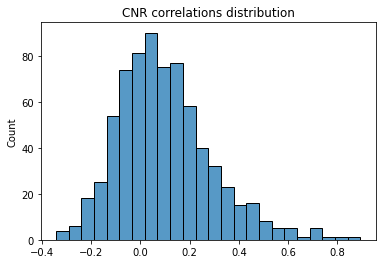

/home/xvvvx/venvs/oncobox/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


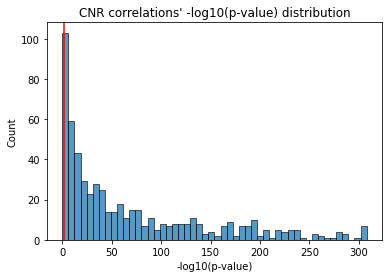

In [11]:
cnr_correlations_path = f"out/pancan/cnr_correlations{(f'_{GENDER}' if GENDER is not None else '')}.tsv"
if not os.path.exists(cnr_correlations_path):
    cnr_correlations_raw = [
        spearmanr(cnrs[tumor_case], cnrs[matched_params["matched_norm_id"]])
        for tumor_case, matched_params in tqdm(matched_pairs_and_norms.items())
    ]
    cnr_correlations = pd.concat([
        anno.filter(["project"]),
        pd.DataFrame(
            list(cnr_correlations_raw),
            index=matched_pairs_and_norms.keys(),
        )], axis=1
    )
    cnr_correlations.dropna().to_csv(cnr_correlations_path, sep="\t")
else:
    print(f"Using cached {cnr_correlations_path}")
cnr_correlations = pd.read_csv(cnr_correlations_path, index_col=0, sep="\t")

seaborn.histplot(cnr_correlations["correlation"].values)
plt.title(
    "CNR correlations distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.show()

ax = seaborn.histplot(-np.log10(cnr_correlations["pvalue"]), bins=50)
ax.set(xlabel="-log10(p-value)")
plt.title(
    "CNR correlations' -log10(p-value) distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.axvline(x=P_THRESHOLD, color="red")
plt.show()

Using cached out/pancan/cnr_correlations(inv).tsv


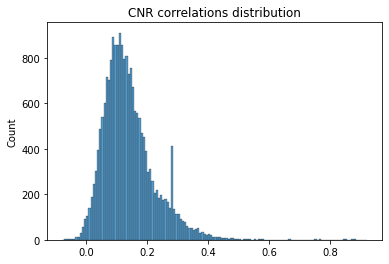

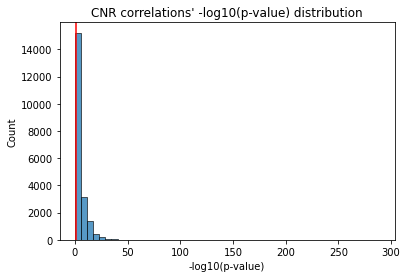

In [12]:
tumor_samples = list(matched_pairs_and_norms.keys())
normal_samples = list(x["matched_norm_id"] for x in matched_pairs_and_norms.values())

cnr_correlations_inv_path = f"out/pancan/cnr_correlations(inv){(f'_{GENDER}' if GENDER is not None else '')}.tsv"
if not os.path.exists(cnr_correlations_inv_path):
    tumor_cnrs = cnrs.filter(tumor_samples, axis=1).values.tolist()
    normal_cnrs = cnrs.filter(normal_samples, axis=1).values.tolist()
    print(cnrs.filter(tumor_samples, axis=1).shape)
    print(cnrs.filter(normal_samples, axis=1).shape)

    zipped_cnrs = zip(tumor_cnrs, normal_cnrs)
    cnr_correlations_inv_raw = [
        spearmanr(_cnrs[0], _cnrs[1])
        for _cnrs in tqdm(zipped_cnrs, total=len(tumor_cnrs))
        if _cnrs[0] and _cnrs[1]
    ]
    _cnr_inv_correlations = pd.DataFrame(cnr_correlations_inv_raw, index=normalized.index)
    _cnr_inv_correlations["fdr_bh"] = stats.p_adjust(FloatVector(_cnr_inv_correlations["pvalue"].values), method="fdr")
    _cnr_inv_correlations.to_csv(cnr_correlations_inv_path, sep="\t")

else:
    print(f"Using cached {cnr_correlations_inv_path}")
cnr_inv_correlations = pd.read_csv(cnr_correlations_inv_path, index_col=0, sep="\t")

seaborn.histplot(cnr_inv_correlations["correlation"].values)
plt.title(
    "CNR correlations distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.show()

ax = seaborn.histplot(-np.log10(cnr_inv_correlations["pvalue"]), bins=50)
ax.set(xlabel="-log10(p-value)")
plt.title(
    "CNR correlations' -log10(p-value) distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.axvline(x=P_THRESHOLD, color="red")
plt.show()

In [13]:
pals_path = f"out/pancan/pals{(f'_{GENDER}' if GENDER is not None else '')}.tsv"
if not os.path.exists(pals_path):
    def calc_matched_pals(tumor_case: str, matched_params: Dict):
        _tumor_pals = calc_pals(normalized, tumor_case, matched_params["matched_avg_ids"])
        _normal_pals = calc_pals(normalized, matched_params["matched_norm_id"], matched_params["matched_avg_ids"])
        return _tumor_pals, _normal_pals


    pals_raw = Parallel(n_jobs=N_PROCS)(
        delayed(calc_matched_pals)(k, v)
        for k, v in tqdm(matched_pairs_and_norms.items())
    )
    _pals = pd.concat(list(chain(*pals_raw)), axis=1)
    _pals.to_csv(pals_path, sep="\t")
else:
    print(f"Using cached {pals_path}")
pals = pd.read_csv(pals_path, index_col=0, sep="\t").filter(filtered_pathways, axis=0)

Using cached out/pancan/pals.tsv


Using cached out/pancan/pal_correlations.tsv


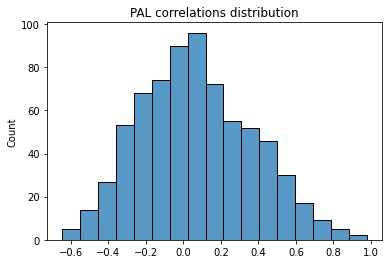

/home/xvvvx/venvs/oncobox/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


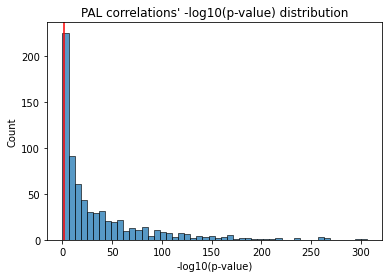

In [14]:
pal_correlations_path = f"out/pancan/pal_correlations{(f'_{GENDER}' if GENDER is not None else '')}.tsv"
if not os.path.exists(pal_correlations_path):
    pal_correlations_raw = [
        spearmanr(pals[tumor_case], pals[matched_params["matched_norm_id"]])
        for tumor_case, matched_params in tqdm(matched_pairs_and_norms.items())
    ]
    _pal_correlations = pd.concat([
        anno.filter(["project"]),
        pd.DataFrame(
            pal_correlations_raw,
            index=matched_pairs_and_norms.keys(),
        )], axis=1
    ).dropna()
    _pal_correlations.to_csv(pal_correlations_path, sep="\t")
else:
    print(f"Using cached {pal_correlations_path}")
pal_correlations = pd.read_csv(pal_correlations_path, index_col=0, sep="\t")

seaborn.histplot(pal_correlations["correlation"].values)
plt.title(
    "PAL correlations distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.show()

ax = seaborn.histplot(-np.log10(pal_correlations["pvalue"]), bins=50)
ax.set(xlabel="-log10(p-value)")
plt.title(
    "PAL correlations' -log10(p-value) distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.axvline(x=P_THRESHOLD, color="red")
plt.show()

Using cached out/pancan/pal_correlations(inv).tsv


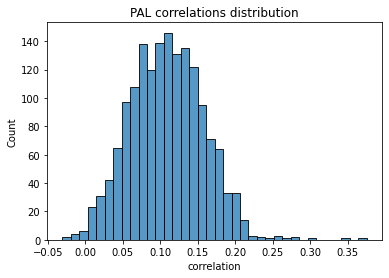

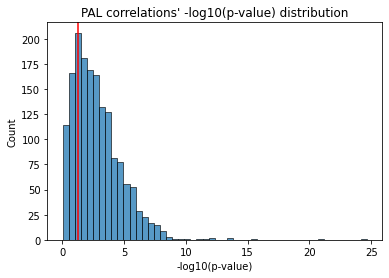

In [15]:
pal_correlations_inv_path = f"out/pancan/pal_correlations(inv){(f'_{GENDER}' if GENDER is not None else '')}.tsv"
if not os.path.exists(pal_correlations_inv_path):
    tumor_pals = pals.filter(tumor_samples).values.tolist()
    normal_pals = pals.filter(normal_samples).values.tolist()

    zipped_pals = zip(tumor_pals, normal_pals)
    pal_correlations_inv_raw = [
        spearmanr(_pals[0], _pals[1])
        for _pals in tqdm(zipped_pals, total=len(tumor_pals))
    ]
    _pal_inv_correlations = pd.DataFrame(pal_correlations_inv_raw, index=pals.index)
    _pal_inv_correlations["fdr_bh"] = stats.p_adjust(FloatVector(_pal_inv_correlations["pvalue"].values), method="fdr")
    _pal_inv_correlations.to_csv(pal_correlations_inv_path, sep="\t")
else:
    print(f"Using cached {pal_correlations_inv_path}")
pal_inv_correlations = pd.read_csv(pal_correlations_inv_path, index_col=0, sep="\t")

# PAL corr
plt.title(
    "PAL correlations distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
seaborn.histplot(pal_inv_correlations["correlation"])
plt.show()

ax = seaborn.histplot(-np.log10(pal_inv_correlations["pvalue"]), bins=50)
ax.set(xlabel="-log10(p-value)")
plt.title(
    "PAL correlations' -log10(p-value) distribution"
    + (f", gender: {GENDER}" if GENDER is not None else "")
)
plt.axvline(x=P_THRESHOLD, color="red")
plt.show()